In [1]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import FloatSlider, FloatLogSlider
from IPython.display import display
import MulensModel as mm
import VBMicrolensing
import matplotlib.lines as mlines

In [2]:
#Function to calculate planet offset required to match the planetary part of the circumbinary caustic
def calculate_planet_offset(s3, q3, psi_deg, s2, q2):
    psi = np.deg2rad(psi_deg)

    # Masses normalized so that total binary mass = 1
    m1 = 1.0 / (1.0 + q2)
    m2 = q2 * m1
    m3 = q3 * m1

    # Lens positions (binary along x, planet offset by s3 at angle psi)
    z1x = -q2 * s2 / (1.0 + q2)
    z2x = s2 / (1.0 + q2)
    z3x = s3 * np.cos(psi) #-q2_fixed * s2_fixed / (1.0 + q2_fixed) + 
    z3y = s3 * np.sin(psi)

    qplanet = m3 / (m1 + m2)

    #Position of planet wrt mass 1 and mass 2
    pA = (z3x - z1x, z3y)
    pB = (z3x - z2x, z3y)
    alphaA = np.arctan2(pA[1], pA[0])
    alphaB = np.arctan2(pB[1], pB[0])
    sA = np.sqrt(pA[0]**2 + pA[1]**2)
    sB = np.sqrt(pB[0]**2 + pB[1]**2)
    qA = m3/m1
    qB = m3/m2
    #position of planet caustic due to mass 1 and mass 2
    rA = ((1-qA)/(1+qA))*(sA - (1./sA))
    rB = ((1-qB)/(1+qB))*(sB - (1./sB))
    rc1 = (z1x + rA*np.cos(alphaA), rA*np.sin(alphaA))
    rc2 = (z2x + rB*np.cos(alphaB), rB*np.sin(alphaB))
    #print(rc1, rc2)

    #Position of circumbinary planet caustic
    rcb = (1./(1+q2))*np.array(rc1) + (q2/(1+q2))*np.array(rc2)
    #print(rcb)
    rcb_norm = np.sqrt(rcb[0]**2 + rcb[1]**2)
    c = rcb_norm*(1 + qplanet)/(1 - qplanet)
    if s3 < 1:
        splanet = np.abs((c - np.sqrt(c**2 + 4))/2)
        psi_new = np.arctan2(-rcb[1], -rcb[0])
    else:
        splanet = (c + np.sqrt(c**2 + 4))/2
        psi_new = np.arctan2(rcb[1], rcb[0])
    
    #print(psi_new)
    if psi_new < 0:
        psi_new += 2*np.pi
    psi_new_deg = np.rad2deg(psi_new)
    return splanet, qplanet, psi_new_deg
    
    










In [ ]:


# Fixed binary parameters (circumbinary host)
s2_fixed = 0.2
q2_fixed = 0.925

# Plot limits and styling
X_MIN, X_MAX = -1, 1
Y_MIN, Y_MAX = -1, 1


def plot_circumbinary_caustics(s3, q3 , psi_deg, s2 = s2_fixed, q2 = q2_fixed ):
    psi = np.deg2rad(psi_deg)

    # Masses normalized so that total binary mass = 1
    m1 = 1.0 / (1.0 + q2)
    m2 = q2 * m1
    m3 = q3 * m1

    # Lens positions (binary along x, planet offset by s3 at angle psi)
    z1x = -q2 * s2 / (1.0 + q2)
    z2x = s2 / (1.0 + q2)
    z3x = s3 * np.cos(psi) #-q2_fixed * s2_fixed / (1.0 + q2_fixed) + 
    z3y = s3 * np.sin(psi)

    # Configure VBMicrolensing for triple-lens caustics
    VBM = VBMicrolensing.VBMicrolensing()
    VBM.Tol = 1e-4
    VBM.SetMethod(VBM.Method.Multipoly)
    vbm_params = [
        z1x, 0.0, m1,  # lens 1 (x, y, m)
        z2x, 0.0, m2,  # lens 2
        z3x, z3y, m3,  # lens 3 (planet)
    ]
    VBM.SetLensGeometry(vbm_params)
    caustics = VBM.Multicaustics()
    critcurves = VBM.Multicriticalcurves()

    # Planetary caustic (relative to planet position and orientation)
    splanet = np.hypot(z3x, z3y)
    qplanet = m3 / (m1 + m2)
    vbm_planet = VBMicrolensing.VBMicrolensing()
    vbm_planet_params = [
        0.0, 0.0, m1+m2,
        z3x, z3y, m3
    ]
    vbm_planet.SetLensGeometry(vbm_planet_params)
    planet_caustic = vbm_planet.Multicaustics()
    planet_caustic_mm = mm.Caustics(s=splanet, q=qplanet) 
    px, py = planet_caustic_mm.get_caustics()
    px, py = np.array(px), np.array(py)
    planetorient = psi
    if planetorient < 0:
        planetorient += 2.0 * np.pi
    pxr = px * np.cos(planetorient) - py * np.sin(planetorient)
    pyr = px * np.sin(planetorient) + py * np.cos(planetorient)

    #shifted planet caustic
    spnew, qp, psi_new_deg = calculate_planet_offset(s3, q3, psi_deg, s2, q2)
    planetorient_new = np.deg2rad(psi_new_deg)
    planet_caustic_new = mm.Caustics(s=spnew, q=qplanet)
    pxnew, pynew = planet_caustic_new.get_caustics()
    pxnew, pynew = np.array(pxnew), np.array(pynew) 
    pxr_new = pxnew * np.cos(planetorient_new) - pynew * np.sin(planetorient_new)
    pyr_new = pxnew * np.sin(planetorient_new) + pynew * np.cos(planetorient_new)



    # Binary-only caustic for reference
    binary_caustic = mm.Caustics(s=s2, q=q2)
    bx, by = binary_caustic.get_caustics()

    # Draw figure
    fig = plt.figure(figsize=(5, 5), dpi=150)
    ax = fig.add_subplot(1, 1, 1)
    plt.subplots_adjust(top=0.9, bottom=0.08, right=0.95, left=0.1, hspace=0.1, wspace=0.2)

    ax.set_xlim(X_MIN, X_MAX)
    ax.set_ylim(Y_MIN, Y_MAX)
    x_left, x_right = ax.get_xlim()
    y_low, y_high = ax.get_ylim()
    ax.set_aspect(abs((x_right - x_left) / (y_high - y_low)))

    # Plot lenses
    ax.scatter([z1x], [0.0], marker='o', s=8, color='goldenrod', label='Binary lenses')
    ax.scatter([z2x], [0.0], marker='o', s=8*q2, color='red')
    ax.scatter([z3x], [z3y], marker='o', s=8, color='black', label='Planet lens')


    

    # Plot caustics
    for cau in caustics:
        ax.plot(cau[0], cau[1], 'k', alpha=1.0, linewidth=0.8)
    #ax.scatter(pxr, pyr, marker='.', s=0.05, color='orange', alpha=0.6)
    for pc in planet_caustic:
        ax.scatter(pc[0], pc[1], marker='.', s=0.05, color='green', alpha=0.6)
    ax.scatter(bx, by, marker='.', s=0.05, color='blue', alpha=0.1)
    ax.scatter(pxr_new, pyr_new, marker='.', s=0.05, color='red', alpha=0.6)
    #plot critical curves for the CB system
    for cc in critcurves:
        ax.plot(cc[0], cc[1], color='gray', linestyle = '--', alpha=1.0, linewidth=0.8)
    
    #Add labels for critical curves and caustics
    black_line = mlines.Line2D([], [], color='black', linestyle='-', label='Circumbinary caustic')
    gray_line = mlines.Line2D([], [], color='gray', linestyle='--', label='Critical curves')
    green_line = mlines.Line2D([], [], color='green', linestyle='-', label='Planet caustic')
    blue_line = mlines.Line2D([], [], color='blue', linestyle='-', label='Binary caustic')
    red_line = mlines.Line2D([], [], color='red', linestyle='-', label='Shifted planet caustic')
    
    #Create legend
    handles, labels = ax.get_legend_handles_labels()
    handles.append(black_line)
    labels.append(black_line.get_label())
    handles.append(gray_line)
    labels.append(gray_line.get_label())
    handles.append(green_line)
    labels.append(green_line.get_label())
    handles.append(blue_line)
    labels.append(blue_line.get_label())
    handles.append(red_line)
    labels.append(red_line.get_label())
    legend = ax.legend(handles, labels, loc="upper left", fontsize=6)
    ax.add_artist(legend)

    ax.set_title(f's3={s3:.3f}, q3={q3:.2e}, psi={psi_deg:.1f}°  |  s2={s2:.2f}, q2={q2:.3f}')
    plt.show()


# Sliders
s2_slider = FloatSlider(value=0.2, min=0.1, max=1, step=0.05, description='s2')
q2_slider = FloatSlider(value=0.925, min=0.1, max=0.99, step=0.01, description='q2')
s3_slider = FloatSlider(value=0.923, min=0.05, max=2.5, step=0.001, description='s3')
q3_slider = FloatLogSlider(value=1e-3, base=10, min=-5, max=-1, step=0.1, description='q3')  # 1e-8 .. 1e-1
psi_slider = FloatSlider(value=0.0, min=0.0, max=360.0, step=1.0, description='psi (deg)')

ui = widgets.VBox([s3_slider, q3_slider, psi_slider, s2_slider, q2_slider])
out = widgets.interactive_output(
    plot_circumbinary_caustics, {"s3": s3_slider, "q3": q3_slider, "psi_deg": psi_slider, "s2": s2_slider, "q2": q2_slider}
)

display(ui, out)


Output()

Display Magnification Maps

In [ ]:
from pathlib import Path
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets

maps_dir = Path("../magnification_maps")
fits_files = sorted(maps_dir.glob("*.fits"))

if not fits_files:
    raise FileNotFoundError(f"No FITS magnification maps found in {maps_dir.resolve()}")

file_dropdown = widgets.Dropdown(
    options=[(path.name, str(path)) for path in fits_files],
    value=str(fits_files[0]),
    description="File:",
    layout=widgets.Layout(width="45%")
)

scale_slider = widgets.FloatRangeSlider(
    description="Scale:",
    readout_format=".3g",
    layout=widgets.Layout(width="45%")
)

x_range_slider = widgets.IntRangeSlider(
    description="X range:",
    layout=widgets.Layout(width="45%")
)

y_range_slider = widgets.IntRangeSlider(
    description="Y range:",
    layout=widgets.Layout(width="45%")
)

output = widgets.Output()
_data_cache = {}

def _load_data(path_str: str) -> np.ndarray:
    if path_str not in _data_cache:
        with fits.open(path_str) as hdul:
            data = hdul[1].data.astype(np.float32)
        _data_cache[path_str] = data
    return _data_cache[path_str]

def _init_controls(*_):
    data = _load_data(file_dropdown.value)
    finite_vals = data[np.isfinite(data)]
    data_min = float(finite_vals.min()) if finite_vals.size else 0.0
    data_max = float(finite_vals.max()) if finite_vals.size else data_min + 1.0
    if data_min == data_max:
        data_max = data_min + 1.0
    step = max((data_max - data_min) / 200.0, 1e-6)

    scale_slider.min = data_min
    scale_slider.max = data_max
    scale_slider.step = step
    scale_slider.value = (data_min, data_max)

    height, width = data.shape
    x_range_slider.min = 0
    x_range_slider.max = width - 1
    x_range_slider.step = 1
    x_range_slider.value = (0, width - 1)

    y_range_slider.min = 0
    y_range_slider.max = height - 1
    y_range_slider.step = 1
    y_range_slider.value = (0, height - 1)

def _render(*_):
    data = _load_data(file_dropdown.value)
    vmin, vmax = scale_slider.value
    if vmin >= vmax:
        vmax = vmin + np.finfo(float).eps
    x_min, x_max = sorted(x_range_slider.value)
    y_min, y_max = sorted(y_range_slider.value)

    height, width = data.shape
    x_min = max(0, min(width - 1, x_min))
    x_max = max(0, min(width - 1, x_max))
    y_min = max(0, min(height - 1, y_min))
    y_max = max(0, min(height - 1, y_max))

    with output:
        output.clear_output(wait=True)
        fig, ax = plt.subplots(figsize=(6, 6))
        extent = [0, width - 1, 0, height - 1]
        image = ax.imshow(
            data,
            cmap="gray",
            origin="lower",
            extent=extent,
            vmin=vmin,
            vmax=vmax,
        )
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)
        ax.set_xlabel("x pixel")
        ax.set_ylabel("y pixel")
        ax.set_title(Path(file_dropdown.value).name)
        plt.colorbar(image, ax=ax, label="Magnification")
        plt.show()

_init_controls()
_render()

file_dropdown.observe(_init_controls, names="value")
file_dropdown.observe(_render, names="value")
scale_slider.observe(_render, names="value")
x_range_slider.observe(_render, names="value")
y_range_slider.observe(_render, names="value")

display(widgets.VBox([
    widgets.HBox([file_dropdown, scale_slider]),
    widgets.HBox([x_range_slider, y_range_slider]),
    output,
]))


In [19]:
with fits.open("../magnification_maps/cb_planet_map_2.fits") as hdul:
            data = hdul[1].data.astype(np.float32)
            header = hdul[1].header
            print(header)

XTENSION= 'IMAGE   '           / Image extension                                BITPIX  =                  -32 / data type of original image                    NAXIS   =                    2 / dimension of original image                    NAXIS1  =                 2000 / length of original image axis                  NAXIS2  =                 2000 / length of original image axis                  PCOUNT  =                    0 / number of parameters                           GCOUNT  =                    1 / number of groups                               S2      =                  0.2                                                  Q2      =                0.925                                                  S3      =                  1.0                                                  Q3      =                0.001                                                  PSI     =                 60.0                                                  RHO     =                0.001          

No contour found


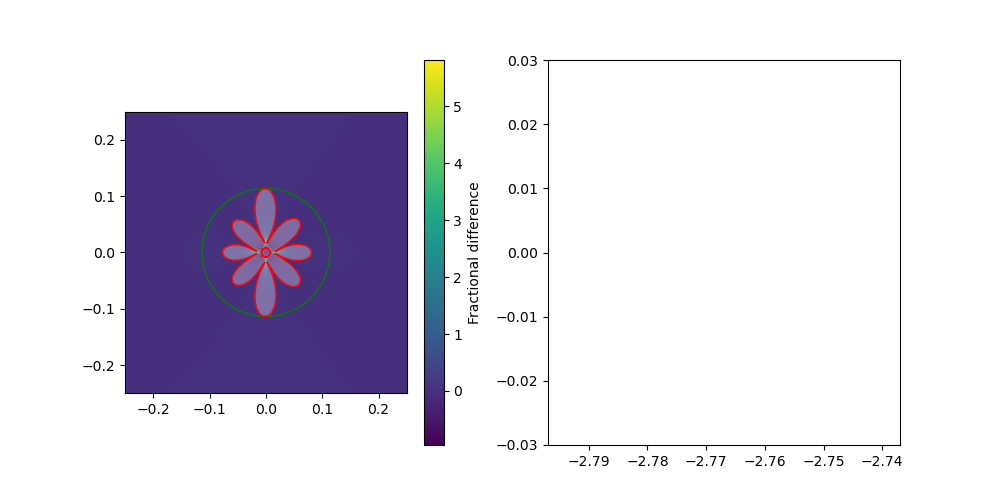

In [7]:
from calc_det_sep import region_of_dev
params = {"s2": 0.2, "q2": 0.925, "s3": 0.35, "q3": 1e-6, "psi": 0.0, "rho": 0.001}
bin_u0, planet_corners=region_of_dev(params, "../oom_detectability", "test", bin_box=0.5, planet_box=0.06, num_cores=8, contour_threshold=0.05, make_plots=True, tE=20)


In [14]:
planet_corners

[(-0.4138775521471982, 0.07072915089410171),
 (-0.7319319720528006, 0.07072915089410171),
 (-0.7319319720528006, -0.07072915089410171),
 (-0.4138775521471982, -0.07072915089410171)]

In [24]:
psi_planet = np.radians(180.0)
res = 12/(10*24*60)
alpha_density = 10
planet_corners_rotated = []
for corner in planet_corners:
    x = corner[0]
    y = corner[1]
    x_rot = x*np.cos(psi_planet) - y*np.sin(psi_planet)
    y_rot = x*np.sin(psi_planet) + y*np.cos(psi_planet)
    planet_corners_rotated.append((x_rot, y_rot))

#Create u list
u = np.arange(-bin_u0, bin_u0, res)

#find the smallest angle between the planet corners
alpha_p1 = np.arctan2(planet_corners_rotated[1][1], planet_corners_rotated[1][0])
alpha_p2 = np.arctan2(planet_corners_rotated[2][1], planet_corners_rotated[2][0])
alpha_pc1 = np.abs(alpha_p1 - alpha_p2)
print(alpha_p1*180/np.pi, alpha_p2*180/np.pi)
if alpha_p1 < 0:
    alpha_p1 = 2*np.pi + alpha_p1
if alpha_p2 < 0:
    alpha_p2 = 2*np.pi + alpha_p2
alpha_pc2 = np.abs(alpha_p1 - alpha_p2)
alpha_planet_corners = np.min([alpha_pc1, alpha_pc2])
alpha_inc = alpha_planet_corners/alpha_density

print(alpha_p1*180/np.pi, alpha_p2*180/np.pi, alpha_inc*180/np.pi)

-5.519553898879643 5.5195538988796295
354.4804461011204 5.5195538988796295 1.103910779775927


In [22]:
planet_corners_rotated

[(0.4138775521471982, -0.07072915089410177),
 (0.7319319720528006, -0.0707291508941018),
 (0.7319319720528006, 0.07072915089410163),
 (0.4138775521471982, 0.07072915089410166)]

In [10]:
from calc_det_sep import calc_detectability
res = 12/(10*24*60)
n_det, n_u, n_alpha = calc_detectability(bin_u0, planet_corners, res, "s3_1p25_q3_1e-3_psi_0", "../oom_detectability/")


Calculating detectability with 273 u values and 292 alpha values


In [11]:
#save a txt file with all trajectories inside bin_u0
bin_u = np.arange(-bin_u0, bin_u0, res)
if n_alpha > 360:
    bin_alpha = np.linspace(0.0, np.pi, 360, endpoint=False)
else:
    bin_alpha = np.linspace(0.0, np.pi, n_alpha, endpoint=False)
det_traj_bin = []
for u in bin_u:
    for alpha in bin_alpha:
        det_traj_bin.append((u, alpha))

bin_u = np.array([traj[0] for traj in det_traj_bin])
bin_alpha = np.array([traj[1] for traj in det_traj_bin])
np.savetxt("../oom_detectability/s3_1p25_q3_1e-3_psi_0/det_traj_bin.txt", np.array([bin_u, np.degrees(bin_alpha)]).T, fmt = '%.4f %.2f', header='u0  alpha(deg)')


In [12]:
#refined detectability
from calc_det_sep import refine_det
n_det_ref = refine_det("../oom_detectability/", "s3_1p25_q3_1e-3_psi_0", threshold=0.05, n_pot=5, num_cores=8)
n_det_bin = refine_det("../oom_detectability/", "s3_1p25_q3_1e-3_psi_0", threshold=0.05, n_pot=5, type = 'bin', num_cores=8)
if n_alpha > 360:
    n_det_bin = n_det_bin*n_alpha/360


Verify algorithm - plot caustics and trajectories

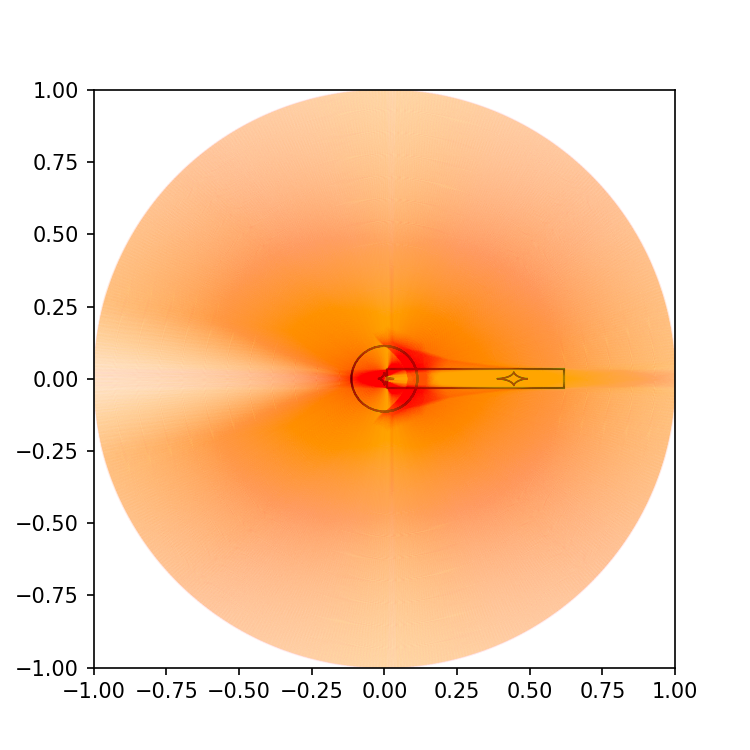

In [14]:
import VBMicrolensing
import numpy as np
import matplotlib.pyplot as plt
res = 12/(10*24*60)
s2 = params["s2"]
q2 = params["q2"]
s3 = params["s3"]
q3 = params["q3"]
psi = params["psi"]*(np.pi/180)
rho = params["rho"]

splanet, qplanet, psi_planet = calculate_planet_offset(s3, q3, psi*(180/np.pi), s2, q2)
psi_planet = np.radians(psi_planet)
planet_corners_rotated = []
for corner in planet_corners:
    x = corner[0]
    y = corner[1]
    x_rot = x*np.cos(psi_planet) - y*np.sin(psi_planet)
    y_rot = x*np.sin(psi_planet) + y*np.cos(psi_planet)
    planet_corners_rotated.append((x_rot, y_rot))

# Masses normalized so that total binary mass = 1
m1 = 1.0 / (1.0 + q2)
m2 = q2 * m1
m3 = q3 * m1

# Lens positions (binary along x, planet offset by s3 at angle psi)
z1x = -q2 * s2 / (1.0 + q2)
z2x = s2 / (1.0 + q2)
z3x = s3 * np.cos(psi) #-q2_fixed * s2_fixed / (1.0 + q2_fixed) + 
z3y = s3 * np.sin(psi)

VBM = VBMicrolensing.VBMicrolensing()
VBM.Tol = 1e-4
VBM.SetMethod(VBM.Method.Multipoly)
vbm_params = [
    z1x, 0.0, m1,  # lens 1 (x, y, m)
    z2x, 0.0, m2,  # lens 2
    z3x, z3y, m3,  # lens 3 (planet)
]
VBM.SetLensGeometry(vbm_params)
caustics = VBM.Multicaustics()
critcurves = VBM.Multicriticalcurves()

all_traj = []
u = np.arange(-bin_u0, bin_u0, res)
alpha = np.linspace(0.0, 2.0*np.pi, 320, endpoint=False)
for u0 in u:
    for alpha0 in alpha:
        all_traj.append((u0, alpha0))

#Read det_traj.txt
ul, alphal, n_points_bin, n_points_planet= np.loadtxt("../oom_detectability/s3_1p25_q3_1e-3_psi_0/det_traj.txt", unpack=True, dtype=float)
det_traj = list(zip(ul, alphal))
tau_range = np.linspace(-1.0, 1.0, 100)
#Plot caustics
fig, ax = plt.subplots(figsize=(5, 5), dpi=150)
for cau in caustics:
    ax.plot(cau[0], cau[1], 'k', alpha=1.0, linewidth=0.8)
#Plot trajectories
"""for traj in all_traj:
    if traj not in det_traj:
        x_traj = -traj[0]*np.sin(traj[1]) + tau_range*np.cos(traj[1])
        y_traj = traj[0]*np.cos(traj[1]) + tau_range*np.sin(traj[1])
        ax.plot(x_traj, y_traj, 'orange', alpha=0.1, linewidth=0.1, linestyle='--')"""
#Plot Detectable Trajectories
for i in range(len(det_traj)):
    traj = det_traj[i]
    x_traj = -traj[0]*np.sin(np.radians(traj[1])) + tau_range*np.cos(np.radians(traj[1]))
    y_traj = traj[0]*np.cos(np.radians(traj[1])) + tau_range*np.sin(np.radians(traj[1]))

    if n_points_bin[i] > 5 and n_points_planet[i] > 5:
        ax.plot(x_traj, y_traj, 'orange', alpha=0.1, linewidth=0.05, linestyle='-')
        #print(traj[0], traj[1], n_points_bin[i], n_points_planet[i])
    else:
        ax.plot(x_traj, y_traj, 'r', alpha=0.05, linewidth=0.05, linestyle='--')

#plot circle with radius binu0
ax.add_patch(plt.Circle((0.0, 0.0), bin_u0, fill=False, color='blue', alpha=1.0))

#plot rectangle with corners planet_corners_rotated
ax.add_patch(plt.Polygon(planet_corners_rotated, color='green', fill=False, linewidth=1.0))

plt.xlim(-1.0, 1.0)
plt.ylim(-1.0, 1.0)
plt.show()




In [20]:
from calc_det_sep import calc_lc

u0 =-0.1126 
alpha = np.radians(7.88)

bin_tau, bin_mag, planet_tau, planet_mag = calc_lc(u0, alpha, "../oom_detectability/", "s3_0p75_q3_1e-3_psi_60", planet=False)


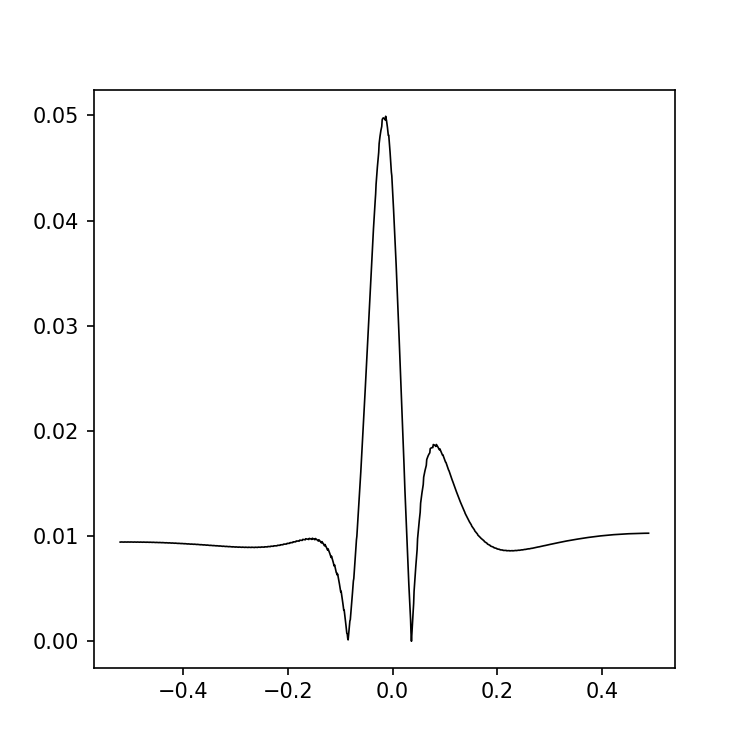

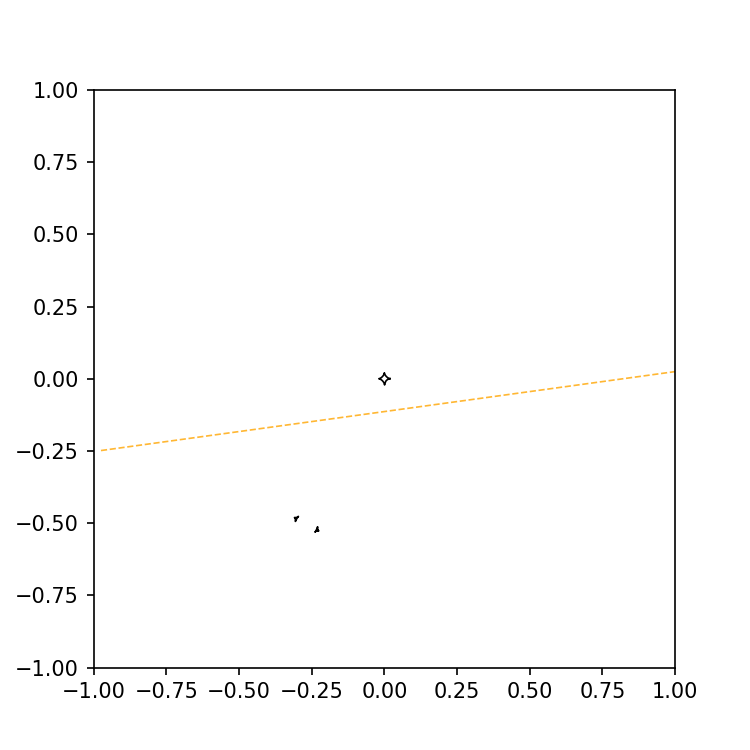

In [21]:
#Plot light curves
fig, ax = plt.subplots(figsize=(5, 5), dpi=150)
ax.plot(bin_tau, np.abs(bin_mag), 'k', alpha=1.0, linewidth=0.8, label='Binary')
#ax.plot(planet_tau, np.abs(planet_mag), 'r', alpha=1.0, linewidth=0.8, label='Planet')
plt.show()

#Plot caustics and trajectory for params
fig, ax = plt.subplots(figsize=(5, 5), dpi=150)
for cau in caustics:
    ax.plot(cau[0], cau[1], 'k', alpha=1.0, linewidth=0.8)


x_traj = -u0*np.sin(alpha) + tau_range*np.cos(alpha)
y_traj = u0*np.cos(alpha) + tau_range*np.sin(alpha)
ax.plot(x_traj, y_traj, 'orange', alpha=0.8, linewidth=0.8, linestyle='--')
plt.xlim(-1.0, 1.0)
plt.ylim(-1.0, 1.0)
plt.show()

In [12]:
n_points_planet = []
planet_mag_abs = np.abs(planet_mag)
mask = planet_mag_abs > 0.05
max_seq = 0
curr_seq = 0
for val in mask:
    if val:
        curr_seq += 1
        if curr_seq > max_seq:
            max_seq = curr_seq
    else:
        curr_seq = 0
n_points_planet.append(max_seq)
print(n_points_planet)

[0]


In [15]:
total_traj = n_u*n_alpha*3./bin_u0
print(total_traj)
print(n_det_ref/total_traj)
print(n_det_ref/(n_u*n_alpha))
print(n_det_ref/n_det_bin)
print(n_det/(n_u*n_alpha))


2107642.229276793
0.014159898480607183
0.3743790456119223
0.47137983320697496
0.5494505494505495


In [184]:
import pandas as pd
#Create input csv file for run_sep_det.py
#Run_name  : s2_0p2_q2_0p925
s2c, q2c, psic, s3c, q3c, rhoc, tEc, cadc, bin_boxc, planet_boxc, contour_thresholdc, alpha_densityc, n_potc = [], [], [], [], [], [], [], [], [], [], [], [], []
logq3l = np.linspace(-7, -3, 9)
for logq3 in logq3l:
    q3 = 10**logq3
    dw = 1. + (3*qplanet**(1./3.)/2)
    dc = 1. - (3*qplanet**(1./3.)/4)
    if q3 >= 10**(-5):
        s3l = np.concatenate((np.linspace(0.35, dc, 10), np.linspace(dw, 2.85, 10)))
    elif q3 == 10**(-5.5):
        s3l = np.concatenate((np.linspace(0.4, dc, 10), np.linspace(dw, 2.85, 10)))
    elif q3 == 10**(-6):
        s3l = np.concatenate((np.linspace(0.5, dc, 10), np.linspace(dw, 2.85, 10)))
    else:
        s3l = np.linspace(dw, 2.85, 10)
    for s3 in s3l:
        psil = np.linspace(0.0, 90.0, 4)
        for psi in psil:
            s2 = 0.2
            q2 = 0.925
            rho = 0.001
            tE = 20
            cad = 12
            bin_box = 0.5
            alpha_density = 10
            n_pot = 5
            contour_threshold = 0.05
            if q3 == 1e-3:
                if s3 <= 0.6 or s3>=1.67:
                    planet_box = 0.5
                else: 
                    planet_box = 1.0
            elif q3 == 10**(-3.5) or q3 == 10**(-4):
                if s3 <= 0.6 or s3>=1.67:
                    planet_box = 0.25
                else: 
                    planet_box = 0.5
            elif q3 == 10**(-4.5) or q3 == 10**(-5):
                if s3 <= 0.6 or s3>=1.67:
                    planet_box = 0.125
                else: 
                    planet_box = 0.25
            elif q3 == 10**(-5.5) or q3 == 10**(-6):
                if s3 <= 0.6 or s3>=1.67:
                    planet_box = 0.06
                else: 
                    planet_box = 0.125
            else:
                planet_box = 0.03  
            s2c.append(s2)
            q2c.append(q2)
            psic.append(psi)
            s3c.append(s3)
            q3c.append(q3)
            rhoc.append(rho)
            tEc.append(tE)
            cadc.append(cad)
            bin_boxc.append(bin_box)
            planet_boxc.append(planet_box)
            contour_thresholdc.append(contour_threshold)
            alpha_densityc.append(alpha_density)
            n_potc.append(n_pot)
        
            
            


    

#save to a csv file with header
input_df = pd.DataFrame({
    "psi": psic,
    "s2": s2c,
    "q2": q2c,
    "s3": s3c,
    "q3": q3c,
    "rho": rhoc,
    "tE": tEc,
    "cad": cadc,
    "bin_box": bin_boxc,
    "planet_box": planet_boxc,
    "contour_threshold": contour_thresholdc,
    "alpha_density": alpha_densityc,
    "n_pot": n_potc
})
input_df.to_csv("../oom_detectability/run1/input.csv", index=False)




In [180]:
(10**logq3l)>10**-5

array([False, False, False, False, False,  True,  True,  True,  True])

ValueError: Contour levels must be increasing

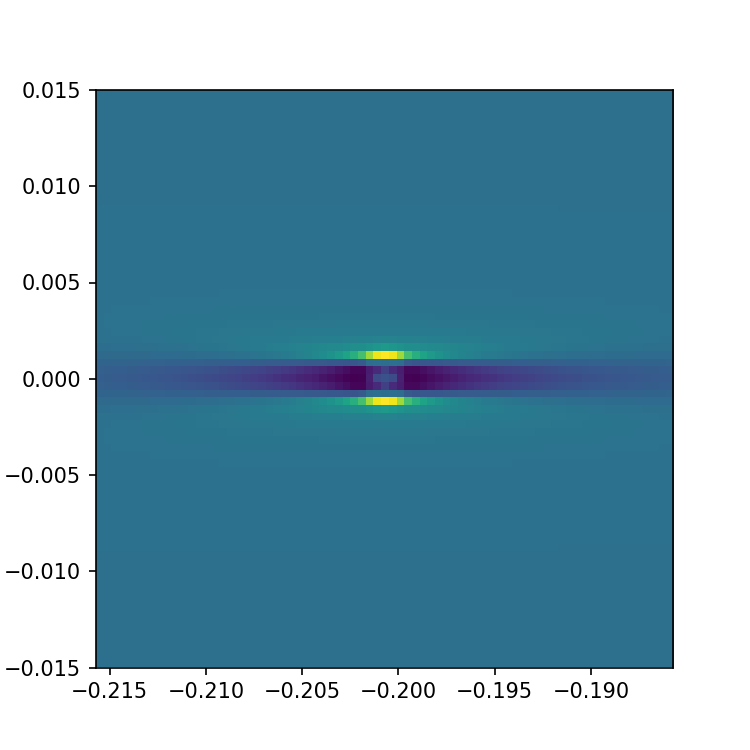

In [183]:
#Create planet magnification map
from magnification_maps import create_mag_map, save_mag_map
import os
res = 0.0004
rho = 0.001
q3 = 10**(-6.5)
splanet, qplanet, psi_planet = calculate_planet_offset(0.9, q3, 70.0, 0.2, 0.925)
x_caustic = ((1-qplanet)/(1+qplanet))*(splanet - (1./splanet))
planet_box = 0.03
tau1 = x_caustic - planet_box/2
tau2 = x_caustic + planet_box/2
u1 = -planet_box/2
u2 = planet_box/2
params = {"s": splanet, "q": qplanet, "rho": 0.001}
planet_map = create_mag_map(params, res=res, box_dim=[(tau1, tau2), (u1, u2)],  num_cores=8, float_precision='float32', backend='auto')
sing_map = create_mag_map({'rho': rho}, res=res, box_dim=[(tau1, tau2), (u1, u2)], num_cores=8, float_precision='float32', backend='auto')
planet_map = (planet_map - sing_map)/sing_map
planet_map_abs = np.abs(planet_map)

# Calculate contours
fig, ax2 = plt.subplots(figsize=(5, 5), dpi=150)
x = np.linspace(tau1, tau2, planet_map.shape[1])
y = np.linspace(u1, u2, planet_map.shape[0])
X, Y = np.meshgrid(x, y)
#plot
im = ax2.imshow(planet_map, origin='lower', extent=[tau1, tau2, u1, u2], cmap='viridis')
# Overlay shaded region for mask > 0.05
cp = ax2.contour(X, Y, planet_map_abs, levels=[0.05], colors='white', linewidths=1.0)
ax2.contourf(X, Y, planet_map_abs,levels=[0.05, np.max(planet_map_abs)], colors='white', alpha=0.3)
plt.colorbar(im, ax=ax2, label='Fractional difference')


plt.show()

In [163]:
len(cp.allsegs[0][0])


29

In [22]:
#Find the right and left edges of the caustic magnification map

x_caustic = x_caustic = ((1-qplanet)/(1+qplanet))*(splanet - (1./splanet))
min_dist_left = np.inf
min_dist_right = np.inf
min_dist_left_point = None
min_dist_right_point = None

for i, segment in enumerate(cp.allsegs[0]):
        for point in segment:
            if np.abs(point[1]) < res and np.abs(point[0] - x_caustic) < min_dist_left and point[0] < x_caustic:
                min_dist_left = np.abs(point[0] - x_caustic)
                min_dist_left_point = point[0]
            if np.abs(point[1]) < res and np.abs(point[0] - x_caustic) < min_dist_right and point[0] > x_caustic:
                min_dist_right = np.abs(point[0] - x_caustic)
                min_dist_right_point = point[0]

planet_left = min_dist_left_point
planet_right = min_dist_right_point
print(planet_left, planet_right)

-0.6953786579944975 -0.34978014700488635


In [18]:
print(x_axis)

[-0.56878439 -0.56778389 -0.56678339 ...  0.05052526  0.05152576
  0.05252626]


In [23]:
print(x_axis)

[-1.        -0.9989995 -0.997999  ...  0.997999   0.9989995  1.       ]
